In [16]:
# run in computer environment gis3
import xarray as xr
import numpy as np
from xarray.backends import NetCDF4DataStore
import salem
from datetime import datetime
from siphon.catalog import TDSCatalog
import cartopy.crs as crs
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from cartopy.io.shapereader import Reader, natural_earth
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geopandas
import os
import netCDF4
import pandas as pd
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.io.shapereader as shpreader
from scipy import stats
from osgeo import gdal,osr,ogr
import gdal
import rasterio
from matplotlib.cm import get_cmap
# import seaborn as sns 
import matplotlib.colors as colors
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import matplotlib as mpl
import dateutil.parser
from netCDF4 import Dataset
from cartopy.feature import NaturalEarthFeature

In [3]:
output_rm_grass = xr.open_dataset('/mnt/e/wrf_tibet/output/rm_grass/wrfout_rm_grass_month_2006-2015_all')
output_control = xr.open_dataset('/mnt/e/wrf_tibet/output/control/wrfout_control_monthly_2006-2015')
output_rm_forest = xr.open_dataset('/mnt/e/wrf_tibet/output/rm_forest/wrfout_rm_forest_month_2006-2015')

output_control=output_control.loc[dict(XTIME=slice('2007', '2015'))]
output_rm_grass=output_rm_grass.loc[dict(XTIME=slice('2007', '2015'))]
output_rm_forest=output_rm_forest.loc[dict(XTIME=slice('2007', '2015'))]

In [4]:
landmask = output_control.LANDMASK[0]
china_mask = salem.open_wrf_dataset('/mnt/e/wrf_tibet/output/geo.nc')
shp_china = geopandas.read_file('/mnt/f/data/shp/China/china8.shp')
china_mask = china_mask.LANDMASK
china_mask=china_mask.salem.roi(shape=shp_china)[0]
mid = output_control.LAKEMASK[0]
mid.data=china_mask.data
china_mask = mid

In [5]:
##   PSFC       surface pressure
##  ACSWDNB     Downward SW surface radiation
##  ACLWDNB     Downward LW surface radiation
##  ACLHF      Upward latent heat flux at surface
##  ACHFX      Upward sensible heat flux at surface
##  ACSWUPB     Upwelling Surface Shortwave Radiation
##  ACLWUPB     Upwelling Surface Longwave Radiation
##  PBLH        Atmospheric Boundary layer thickness

In [6]:




output_control_spin = output_control[['TSK','RAINNC','PSFC','ACSWDNB','ACLWDNB','ACLHF',
                                      'ACHFX','ACSWUPB','ACLWUPB','PBLH']]
output_rm_grass_spin = output_rm_grass[['TSK','RAINNC','PSFC','ACSWDNB','ACLWDNB','ACLHF',
                                      'ACHFX','ACSWUPB','ACLWUPB','PBLH']]


output_control_spin = output_control_spin.where(china_mask==1)
output_rm_grass_spin = output_rm_grass_spin.where(china_mask==1)


In [47]:
output_control_spin_season_series = output_control_spin.TSK.resample(XTIME='Q-FEB').mean()
output_rm_grass_spin_season_series = output_rm_grass_spin.TSK.resample(XTIME='Q-FEB').mean()


output_control_spin_season_series=output_control_spin_season_series.where(china_mask==1)
output_rm_grass_spin_season_series=output_rm_grass_spin_season_series.where(china_mask==1)

output_control_rain_spin_season_series = output_control_spin.RAINNC.resample(XTIME='Q-FEB').mean()
output_rm_grass_rain_spin_season_series = output_rm_grass_spin.RAINNC.resample(XTIME='Q-FEB').mean()
output_control_rain_spin_season_series = output_control_rain_spin_season_series.where(china_mask==1)
output_rm_grass_rain_spin_season_series = output_rm_grass_rain_spin_season_series.where(china_mask==1)

In [8]:
#monthly mean surface temperature
tsk_mon_control = output_control_spin.TSK.groupby('XTIME.month').mean()
tsk_mon_rm_grass = output_rm_grass_spin.TSK.groupby('XTIME.month').mean()


tsk_mon_control=tsk_mon_control.where(china_mask==1)
tsk_mon_rm_grass=tsk_mon_rm_grass.where(china_mask==1)


#seasonal mean surface temeprature
tsk_season_control = output_control_spin.TSK.groupby('XTIME.season').mean()
tsk_season_rm_grass = output_rm_grass_spin.TSK.groupby('XTIME.season').mean()


tsk_season_control=tsk_season_control.where(china_mask==1)
tsk_season_rm_grass=tsk_season_rm_grass.where(china_mask==1)


#seasonal total precipitation accumulated
rainnc_season = output_control_spin.RAINNC.resample(XTIME='Q-FEB').mean()
precipitation_mam_control = (rainnc_season.sel(XTIME='2015-05')[0] - rainnc_season.sel(XTIME='2007-05')[0])/8
precipitation_jja_control = (rainnc_season.sel(XTIME='2015-08')[0] - rainnc_season.sel(XTIME='2007-08')[0])/8
precipitation_son_control = (rainnc_season.sel(XTIME='2015-11')[0] - rainnc_season.sel(XTIME='2007-11')[0])/8
precipitation_djf_control = (rainnc_season.sel(XTIME='2015-02')[0] - rainnc_season.sel(XTIME='2007-02')[0])/8



In [9]:
date_var = []
for i in range(2007,2016):
    for j in range(1,13):
        txt = str(i)+'-'+str(j)
        date_var.append(txt)

In [40]:
def tsk_effect_season(data_spin,data_season,season_months,season_str):
    #data:output_control_spin_season_series
    #mam-month=5, jja-month=8, son-month=11,djf-month=2
    tsk_spin_control = output_control_spin_season_series.sel(XTIME=output_control_spin_season_series['XTIME.month']==season_months)
    tsk_spin_data= data_spin.sel(XTIME=data_spin['XTIME.month']==season_months) 
    tsk_season_effect = data_season.sel(season=season_str) - tsk_season_control.sel(season=season_str)
    ttest,pvalue = stats.ttest_ind(tsk_spin_control,tsk_spin_data)
    box = output_control_spin.TSK[0] 
    box["p"]=(['y', 'x'],  pvalue)
    lons_p = box.lon
    lats_p = box.lat
    lons_sig = lons_p.where(lons_p.p<0.05)
    lats_sig = lats_p.where(lats_p.p<0.05)
    return (tsk_season_effect,lons_sig,lats_sig)

In [41]:

def tsk_effect_mon(data_spin,data_mon,months):
    #data:output_control_spin
    tsk_spin_control = output_control_spin.TSK.sel(XTIME=output_control_spin.TSK['XTIME.month']==months)
    tsk_spin_data= data_spin.TSK.sel(XTIME=data_spin.TSK['XTIME.month']==months) 
    tsk_mon_effect = data_mon.sel(month=months) - tsk_mon_control.sel(month=months)
    ttest,pvalue = stats.ttest_ind(tsk_spin_control,tsk_spin_data)
    box = output_control_spin.TSK[0]
    box["p"]=(['y', 'x'],  pvalue)
    lons_p = box.lon
    lats_p = box.lat
    lons_sig = lons_p.where(lons_p.p<0.05)
    lats_sig = lats_p.where(lats_p.p<0.05)
    return (tsk_mon_effect,lons_sig,lats_sig)

In [77]:
precip_effect_season(output_rm_grass_rain_spin_season_series,0)[0]

<xarray.DataArray (y: 171, x: 231)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lon      (y, x) float32 82.610504 82.83075 83.05139 ... 161.2799 161.61536
    lat      (y, x) float32 8.361839 8.439087 8.515778 ... 48.310043 48.142765
Dimensions without coordinates: y, x

In [78]:
def precip_effect_season(data,season_month):
    if season_month>0:
        
    #data = output_rm_grass_spin / output_rm_forest_spin
        precipitation_jan=np.zeros(171*231).reshape(171,231)
        precipitation_jan_grass=np.zeros(171*231).reshape(171,231)
        date_var = output_control_rain_spin_season_series.XTIME.data
        var1 = date_var[(season_month-1):37:4][0:9]
        var2 = date_var[season_month:37:4][0:9]
        box = []
        box_grass=[]
        for i in range(0,9):
            pre_accu_jan = output_control_rain_spin_season_series.sel(XTIME = var2[i]) - output_control_rain_spin_season_series.sel(XTIME = var1[i])
            pre_accu_jan_grass = data.sel(XTIME = var2[i]) - data.sel(XTIME = var1[i])
            precipitation_jan=precipitation_jan+pre_accu_jan
            precipitation_jan_grass=precipitation_jan_grass+pre_accu_jan_grass
            box.append(pre_accu_jan)
            box_grass.append(pre_accu_jan_grass)
        pre_jan_control = precipitation_jan/9
        pre_jan_grass = precipitation_jan_grass/9
        pre_jan_grass_minus_control = pre_accu_jan_grass - pre_accu_jan
    else:
        precipitation_jan=np.zeros(171*231).reshape(171,231)
        precipitation_jan_grass=np.zeros(171*231).reshape(171,231)
        date_var = output_control_rain_spin_season_series.XTIME.data 
        var1 = date_var[3:37:4][0:8]
        var2 = date_var[0:37:4][1:9]
        box = []
        box_grass=[]
        for i in range(0,8):
            pre_accu_jan = output_control_rain_spin_season_series.sel(XTIME = var2[i]) - output_control_rain_spin_season_series.sel(XTIME = var1[i])
            pre_accu_jan_grass = data.sel(XTIME = var2[i]) - data.sel(XTIME = var1[i])
            precipitation_jan=precipitation_jan+pre_accu_jan
            precipitation_jan_grass=precipitation_jan_grass+pre_accu_jan_grass
            box.append(pre_accu_jan)
            box_grass.append(pre_accu_jan_grass)
        pre_jan_control = precipitation_jan/8
        pre_jan_grass = precipitation_jan_grass/8
        pre_jan_grass_minus_control = pre_accu_jan_grass - pre_accu_jan
    ttest,pvalue = stats.ttest_ind(box,box_grass)
    con = output_control_spin.RAINNC[0]
    con["p"]=(['y', 'x'],  pvalue)
    lons_p = con.lon
    lats_p = con.lat
    lons_sig = lons_p.where(lons_p.p<0.05)
    lats_sig = lats_p.where(lats_p.p<0.05)
    return (pre_jan_grass_minus_control,lons_sig,lats_sig)

In [43]:
def precip_effect(data,month):
    if month<12:
        
    #data = output_rm_grass_spin / output_rm_forest_spin
        precipitation_jan=np.zeros(171*231).reshape(171,231)
        precipitation_jan_grass=np.zeros(171*231).reshape(171,231)
        var1 = date_var[(month-1):108:12]
        var2 = date_var[month:108:12]
        box = []
        box_grass=[]
        for i in range(0,9):
            pre_accu_jan = output_control_spin.RAINNC.sel(XTIME = var2[i])[0] - output_control_spin.RAINNC.sel(XTIME = var1[i])[0]
            pre_accu_jan_grass = data.RAINNC.sel(XTIME = var2[i])[0] - data.RAINNC.sel(XTIME = var1[i])[0]
            precipitation_jan=precipitation_jan+pre_accu_jan
            precipitation_jan_grass=precipitation_jan_grass+pre_accu_jan_grass
            box.append(pre_accu_jan)
            box_grass.append(pre_accu_jan_grass)
        pre_jan_control = precipitation_jan/9
        pre_jan_grass = precipitation_jan_grass/9
        pre_jan_grass_minus_control = pre_accu_jan_grass - pre_accu_jan
    else:
        precipitation_jan=np.zeros(171*231).reshape(171,231)
        precipitation_jan_grass=np.zeros(171*231).reshape(171,231)
        var1 = date_var[(month-1):108:12]
        var2 = date_var[month:108:12]
        box = []
        box_grass=[]
        for i in range(0,8):
            pre_accu_jan = output_control_spin.RAINNC.sel(XTIME = var2[i])[0] - output_control_spin.RAINNC.sel(XTIME = var1[i])[0]
            pre_accu_jan_grass = data.RAINNC.sel(XTIME = var2[i])[0] - data.RAINNC.sel(XTIME = var1[i])[0]
            box.append(pre_accu_jan)
            box_grass.append(pre_accu_jan_grass)
            precipitation_jan=precipitation_jan+pre_accu_jan
            precipitation_jan_grass=precipitation_jan_grass+pre_accu_jan_grass
        pre_jan_control = precipitation_jan/8
        pre_jan_grass = precipitation_jan_grass/8
        pre_jan_grass_minus_control = pre_accu_jan_grass - pre_accu_jan
    ttest,pvalue = stats.ttest_ind(box,box_grass)
    con = output_control_spin.RAINNC[0]
    con["p"]=(['y', 'x'],  pvalue)
    lons_p = con.lon
    lats_p = con.lat
    lons_sig = lons_p.where(lons_p.p<0.05)
    lats_sig = lats_p.where(lats_p.p<0.05)
    return (pre_jan_grass_minus_control,lons_sig,lats_sig)

In [26]:
def plot_china(data,limit,grid0):
#    limit = np.linspace(-2,2,50)
    p0=grid[grid0].contourf(to_np(lons), to_np(lats), to_np(data),
             transform=crs.PlateCarree(),
             cmap='bwr',
            levels=limit,
            extend='both')
    grid[grid0].coastlines('50m', linewidth=0.8)
    grid[grid0].add_geometries(china.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
    grid[grid0].add_geometries(state_shapes.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
    grid[grid0].gridlines(color="black", linestyle="dotted",linewidth=1.0)



In [13]:
#rm_grass impacts on surface temperature
#mam
tsk_mam_grass_minus_control = tsk_season_rm_grass.sel(season='MAM') - tsk_season_control.sel(season='MAM')
#jja
tsk_jja_grass_minus_control = tsk_season_rm_grass.sel(season='JJA') - tsk_season_control.sel(season='JJA')
#son
tsk_son_grass_minus_control = tsk_season_rm_grass.sel(season='SON') - tsk_season_control.sel(season='SON')
#djf
tsk_djf_grass_minus_control = tsk_season_rm_grass.sel(season='DJF') - tsk_season_control.sel(season='DJF')


In [14]:
shapefile='/mnt/f/data/shp/Tibet/TP_WGS84.shp'
china = shpreader.Reader('/mnt/f/data/shp/China/china8.shp')
state_shapes = shpreader.Reader(shapefile)
ncfile = Dataset("/mnt/e/wrf_tibet/test/tibet/wrfinput_d01")
slp = getvar(ncfile, "HGT")
slp = getvar(ncfile, "HGT")
smooth=smooth2d(slp, 3, cenweight=4)
# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)
projection = cart_proj
axes_class = (GeoAxes,
              dict(map_projection=projection))

[Text(1, -1.0, '-1.0'),
 Text(1, -0.8, '-0.8'),
 Text(1, -0.6, '-0.6'),
 Text(1, -0.4, '-0.4'),
 Text(1, -0.19999999999999996, '-0.2'),
 Text(1, 0.0, '0'),
 Text(1, 0.19999999999999996, '0.2'),
 Text(1, 0.3999999999999999, '0.4'),
 Text(1, 0.6000000000000001, '0.6'),
 Text(1, 0.8, '0.8'),
 Text(1, 1.0, '1.0')]

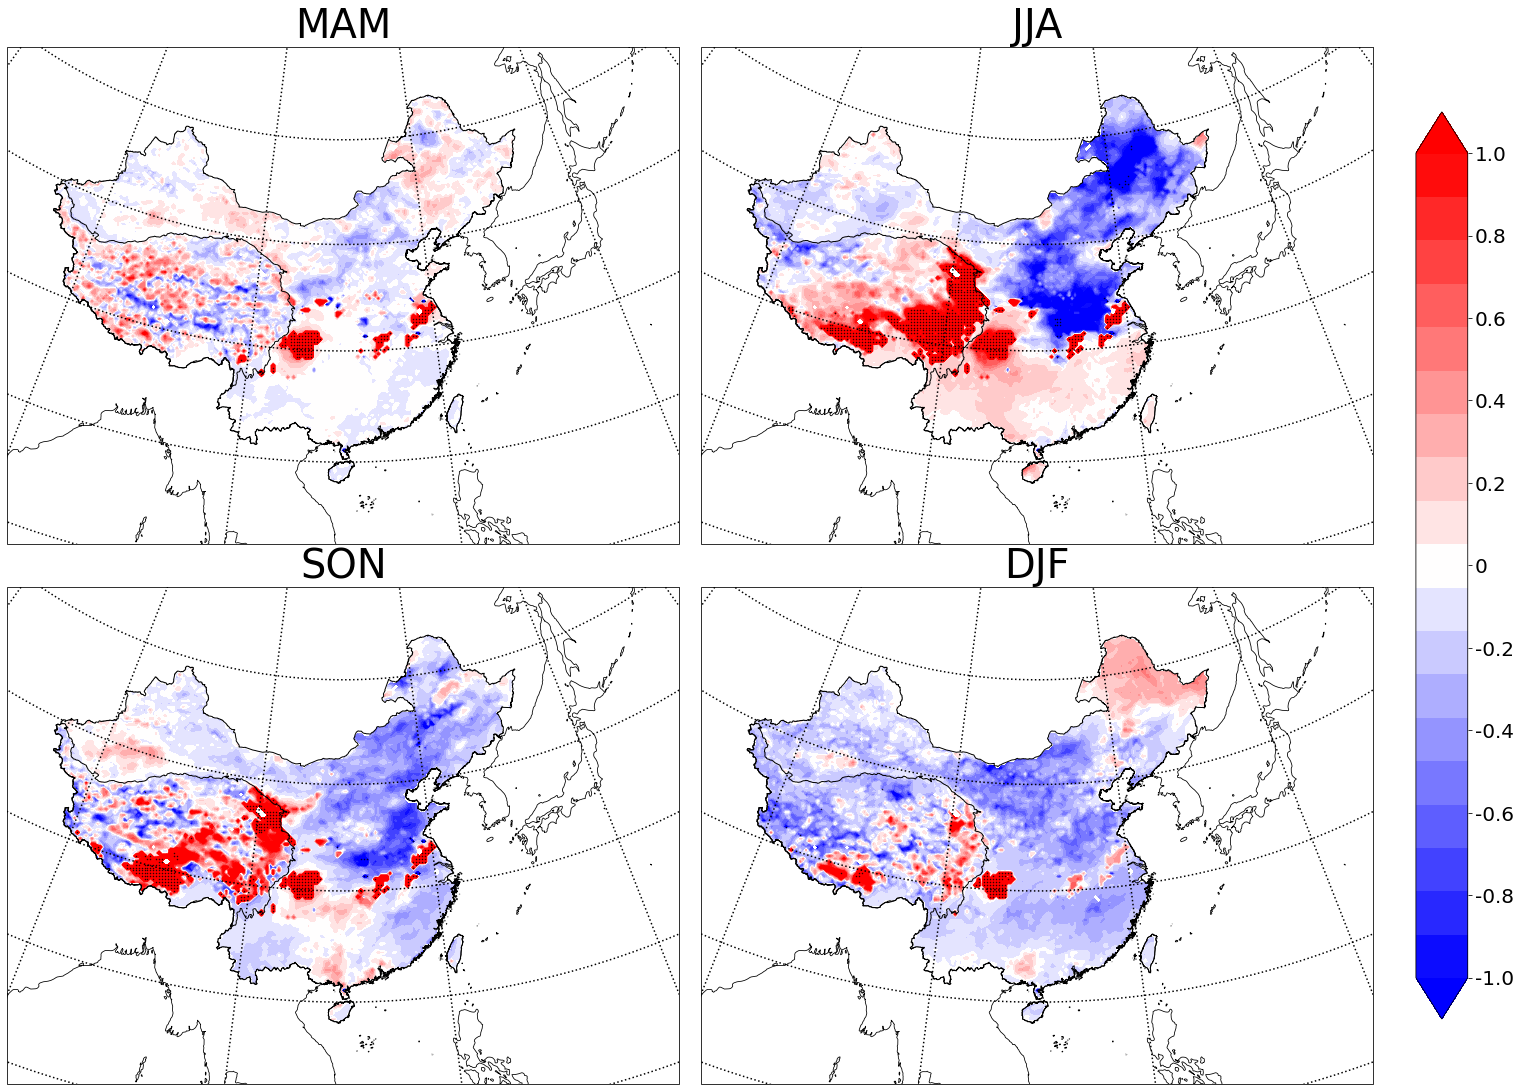

In [44]:

# make plot


fig = plt.figure(figsize=(24, 18))

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.set_facecolor('none')
fig.set_edgecolor('none')

grid = AxesGrid(fig, 111, axes_class=axes_class,
                 nrows_ncols=(2, 2),
                 axes_pad=(0.3, 0.6),  # pad between axes in inch.
#                  cbar_location='bottom',
#                  cbar_mode='single',
#                  cbar_pad=0.2,
#                  cbar_size='5%',
                 share_all=True,
                 label_mode=" ")
# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
p0=grid[0].contourf(to_np(lons), to_np(lats), 
                    to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,5,'MAM')[0]),
             transform=crs.PlateCarree(),
             cmap='bwr',
            levels=np.linspace(-1,1,20),
                    extend='both'
                   )
#grid[0].add_feature(states, linewidth=.5, edgecolor="black")
grid[0].coastlines('50m', linewidth=0.8)
grid[0].add_geometries(china.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[0].add_geometries(state_shapes.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0)
grid[0].scatter(to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,5,'MAM')[1]),
                to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,5,'MAM')[2]),
                s=0.2,c='k',transform=crs.PlateCarree())




grid[1].add_feature(states, linewidth=.5, edgecolor="black")
grid[1].coastlines('50m', linewidth=0.8)
grid[1].add_geometries(china.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[1].add_geometries(state_shapes.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 

p1=grid[1].contourf(to_np(lons), to_np(lats), 
                    to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,8,'JJA')[0]),
             transform=crs.PlateCarree(),
             cmap='bwr',
            levels=np.linspace(-1,1,20),
                    extend='both'
            )
grid[1].scatter(to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,8,'JJA')[1]),
                to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,8,'JJA')[2]),
                s=0.2,c='k',transform=crs.PlateCarree())

grid[2].add_feature(states, linewidth=.5, edgecolor="black")
grid[2].coastlines('50m', linewidth=0.8)
grid[2].add_geometries(china.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[2].add_geometries(state_shapes.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
p2=grid[2].contourf(to_np(lons), to_np(lats), 
                    to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,11,'SON')[0]),
             transform=crs.PlateCarree(),
             cmap='bwr',
            levels=np.linspace(-1,1,20),
            extend='both'
            )
grid[2].scatter(to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,11,'SON')[1]),
                to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,11,'SON')[2]),
                s=0.2,c='k',transform=crs.PlateCarree())


grid[3].add_feature(states, linewidth=.5, edgecolor="black")
grid[3].coastlines('50m', linewidth=0.8)
grid[3].add_geometries(china.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[3].add_geometries(state_shapes.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
p3=grid[3].contourf(to_np(lons), to_np(lats), 
                    to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,2,'DJF')[0]),
             transform=crs.PlateCarree(),
             cmap='bwr',
            levels=np.linspace(-1,1,20),
                                extend='both'
            )
grid[3].scatter(to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,2,'DJF')[1]),
                to_np(tsk_effect_season(output_rm_grass_spin_season_series,tsk_season_rm_grass,2,'DJF')[2]),
                s=0.2,c='k',transform=crs.PlateCarree())
# Add a color bar
#cb = grid.cbar_axes[0].colorbar(p1,extend='both')
#cb.ax.tick_params(axis='y',direction='in')
#cb.ax.set_yticklabels([-2,-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6,2.0],fontsize=14)
#cb.set_label_text(r'$\Delta$LST(℃)',fontsize=30)

# Set the map bounds
grid[0].set_xlim(cartopy_xlim(smooth))
grid[0].set_ylim(cartopy_ylim(smooth))

# Add the gridlines
grid[0].gridlines(color="black", linestyle="dotted",linewidth=1.5)
grid[1].gridlines(color="black", linestyle="dotted",linewidth=1.5)
grid[2].gridlines(color="black", linestyle="dotted",linewidth=1.5)
grid[3].gridlines(color="black", linestyle="dotted",linewidth=1.5)

grid[0].set_title('MAM',fontsize=40)
grid[1].set_title('JJA',fontsize=40)
grid[2].set_title('SON',fontsize=40)
grid[3].set_title('DJF',fontsize=40)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cb = fig.colorbar(p3,cax=cbar_ax, orientation='vertical')

cb.set_ticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
cb.ax.set_yticklabels([-1.0,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=20)

[Text(1, -1.0, '-1.0'),
 Text(1, -0.8, '-0.8'),
 Text(1, -0.6, '-0.6'),
 Text(1, -0.4, '-0.4'),
 Text(1, -0.19999999999999996, '-0.2'),
 Text(1, 0.0, '0'),
 Text(1, 0.19999999999999996, '0.2'),
 Text(1, 0.3999999999999999, '0.4'),
 Text(1, 0.6000000000000001, '0.6'),
 Text(1, 0.8, '0.8'),
 Text(1, 1.0, '1.0')]

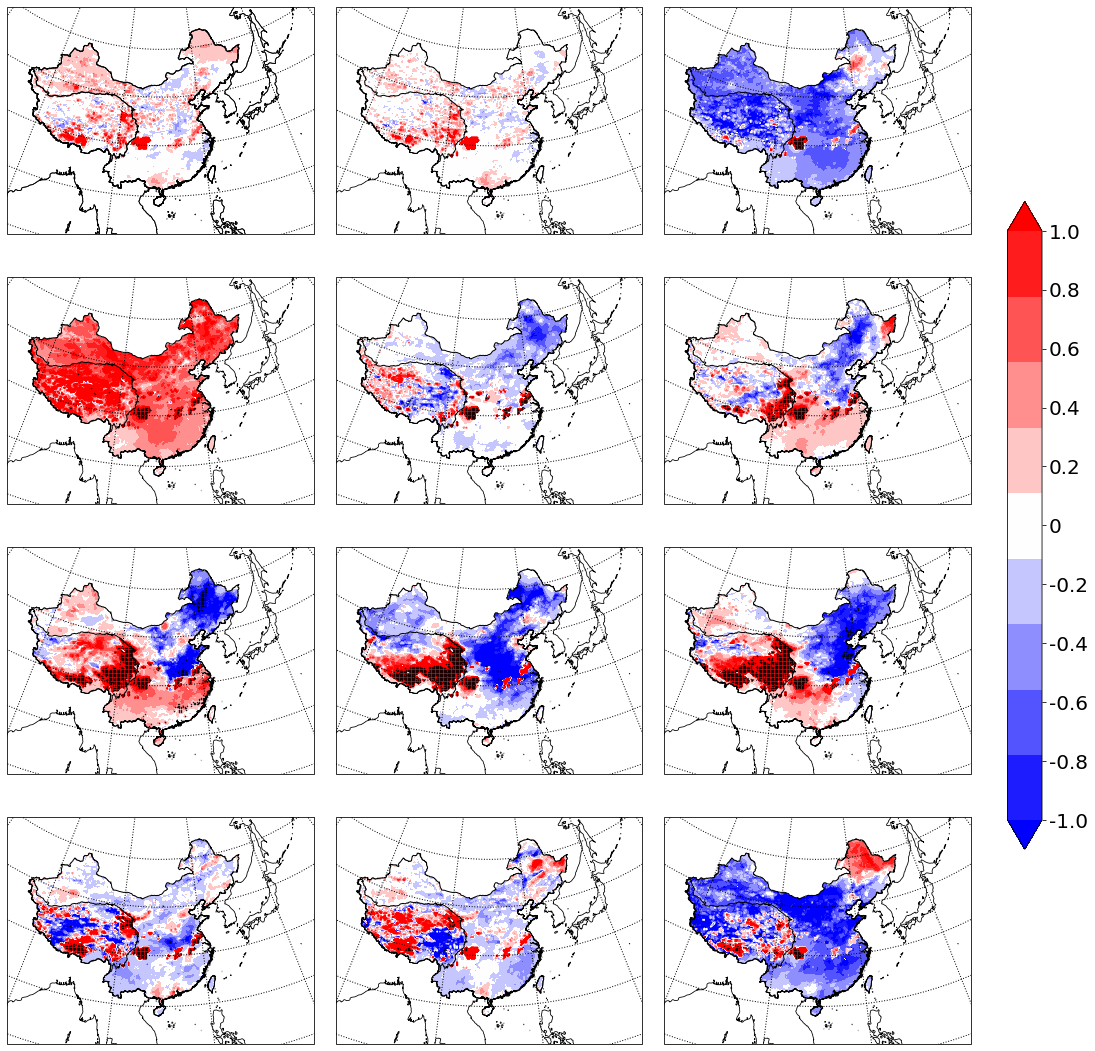

In [45]:
# monthly grass temperature effect

# make plot
pre_limit = np.linspace(-1,1,10)

fig = plt.figure(figsize=(24, 18))

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.set_facecolor('none')
fig.set_edgecolor('none')

grid = AxesGrid(fig, 111, axes_class=axes_class,
                 nrows_ncols=(4, 3),
                 axes_pad=(0.3, 0.6),  # pad between axes in inch.
#                  cbar_location='bottom',
#                  cbar_mode='single',
#                  cbar_pad=0.2,
#                  cbar_size='5%',
                 share_all=True,
                 label_mode=" ")
p1=grid[0].contourf(to_np(lons),
                    to_np(lats),to_np(tsk_effect_mon(output_rm_grass_spin,tsk_mon_rm_grass,1)[0]),50,
                    transform=crs.PlateCarree(),
                    cmap='bwr',
                    levels=pre_limit,
                    extend='both')
grid[0].coastlines('50m', linewidth=0.8)
grid[0].add_geometries(china.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[0].add_geometries(state_shapes.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[0].set_xlim(cartopy_xlim(smooth))
grid[0].set_ylim(cartopy_ylim(smooth))
for i in range(1,13):
    data = tsk_effect_mon(output_rm_grass_spin,tsk_mon_rm_grass,i)[0]
    grid0 = i-1
    plot_china(data,pre_limit,grid0)
    grid[grid0].scatter(to_np(tsk_effect_mon(output_rm_grass_spin,tsk_mon_rm_grass,i)[1]),
                to_np(tsk_effect_mon(output_rm_grass_spin,tsk_mon_rm_grass,i)[2]),
                s=0.2,c='k',transform=crs.PlateCarree())
cbar_ax = fig.add_axes([0.8, 0.25, 0.02, 0.5]) #[与主图间隔，上下位置，宽度，高度]
cb=fig.colorbar(p1,cax=cbar_ax,
                orientation='vertical')

cb.set_ticks(ticks=[-1.0,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0])
cb.ax.set_yticklabels([-1.0,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=20)

[Text(1, -50.0, '-50'),
 Text(1, -40.0, '-40'),
 Text(1, -30.0, '-30'),
 Text(1, -20.0, '-20'),
 Text(1, -9.999999999999996, '-10'),
 Text(1, 0.0, '0'),
 Text(1, 10.0, '10'),
 Text(1, 20.0, '20'),
 Text(1, 30.000000000000007, '30'),
 Text(1, 40.00000000000001, '40'),
 Text(1, 50.0, '50')]

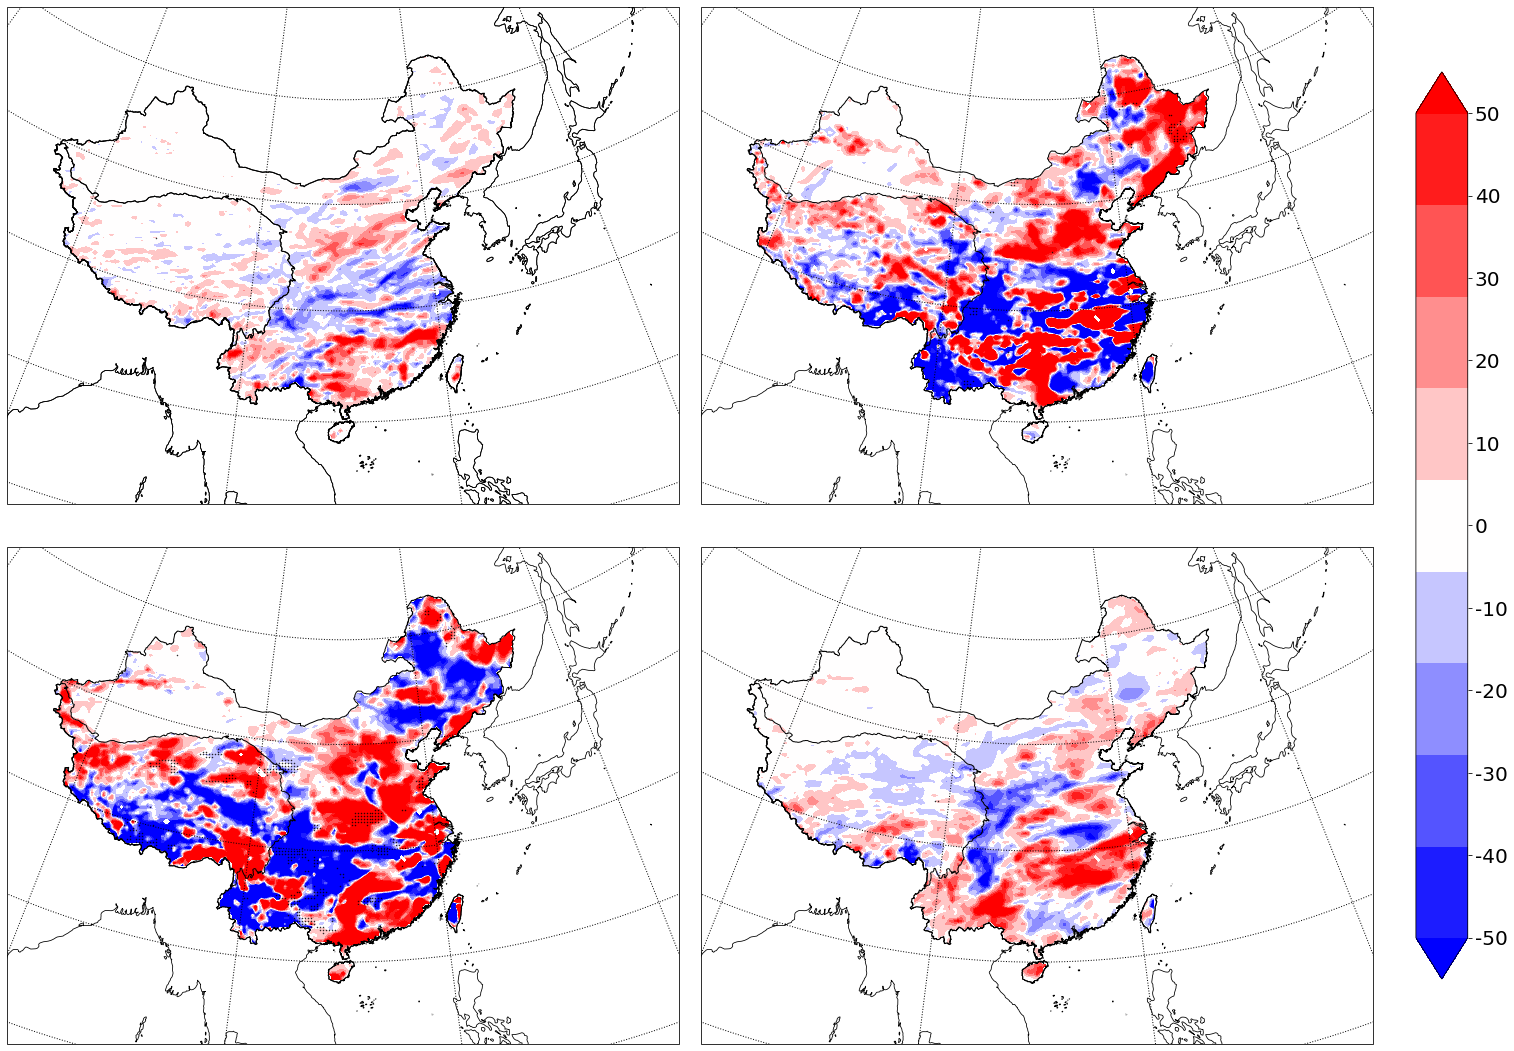

In [83]:
#seasonal precipitation effect

# make plot
pre_limit = np.linspace(-50,50,10)

fig = plt.figure(figsize=(24, 18))

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.set_facecolor('none')
fig.set_edgecolor('none')

grid = AxesGrid(fig, 111, axes_class=axes_class,
                 nrows_ncols=(2,2),
                 axes_pad=(0.3, 0.6),  # pad between axes in inch.
#                  cbar_location='bottom',
#                  cbar_mode='single',
#                  cbar_pad=0.2,
#                  cbar_size='5%',
                 share_all=True,
                 label_mode=" ")
p1=grid[0].contourf(to_np(lons),
                    to_np(lats),to_np(precip_effect_season(output_rm_grass_rain_spin_season_series,1)[0]),50,
                    transform=crs.PlateCarree(),
                    cmap='bwr',
                    levels=pre_limit,
                    extend='both')
grid[0].coastlines('50m', linewidth=0.8)
grid[0].add_geometries(china.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[0].add_geometries(state_shapes.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[0].set_xlim(cartopy_xlim(smooth))
grid[0].set_ylim(cartopy_ylim(smooth))
for i in range(1,4):
    data = precip_effect_season(output_rm_grass_rain_spin_season_series,i)[0]
    grid0 = i-1
    plot_china(data,pre_limit,grid0)
    grid[grid0].scatter(to_np(precip_effect_season(output_rm_grass_rain_spin_season_series,i)[1]),
                to_np(precip_effect_season(output_rm_grass_rain_spin_season_series,i)[2]),
                s=0.2,c='k',transform=crs.PlateCarree())
data = precip_effect_season(output_rm_grass_rain_spin_season_series,0)[0]
plot_china(data,pre_limit,3)
grid[3].scatter(to_np(precip_effect_season(output_rm_grass_rain_spin_season_series,0)[1]),
            to_np(precip_effect_season(output_rm_grass_rain_spin_season_series,0)[2]),
            s=0.2,c='k',transform=crs.PlateCarree())

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7]) #[与主图间隔，上下位置，宽度，高度]
cb=fig.colorbar(p1,cax=cbar_ax,
                orientation='vertical')

cb.set_ticks(ticks=[-50,-40,-30,-20,-10,0,10,20,30,40,50,60])
cb.ax.set_yticklabels([-50,-40,-30,-20,-10,0,10,20,30,40,50],fontsize=20)

[Text(1, -50.0, '-50'),
 Text(1, -40.0, '-40'),
 Text(1, -30.0, '-30'),
 Text(1, -20.0, '-20'),
 Text(1, -9.999999999999996, '-10'),
 Text(1, 0.0, '0'),
 Text(1, 10.0, '10'),
 Text(1, 20.0, '20'),
 Text(1, 30.000000000000007, '30'),
 Text(1, 40.00000000000001, '40'),
 Text(1, 50.0, '50')]

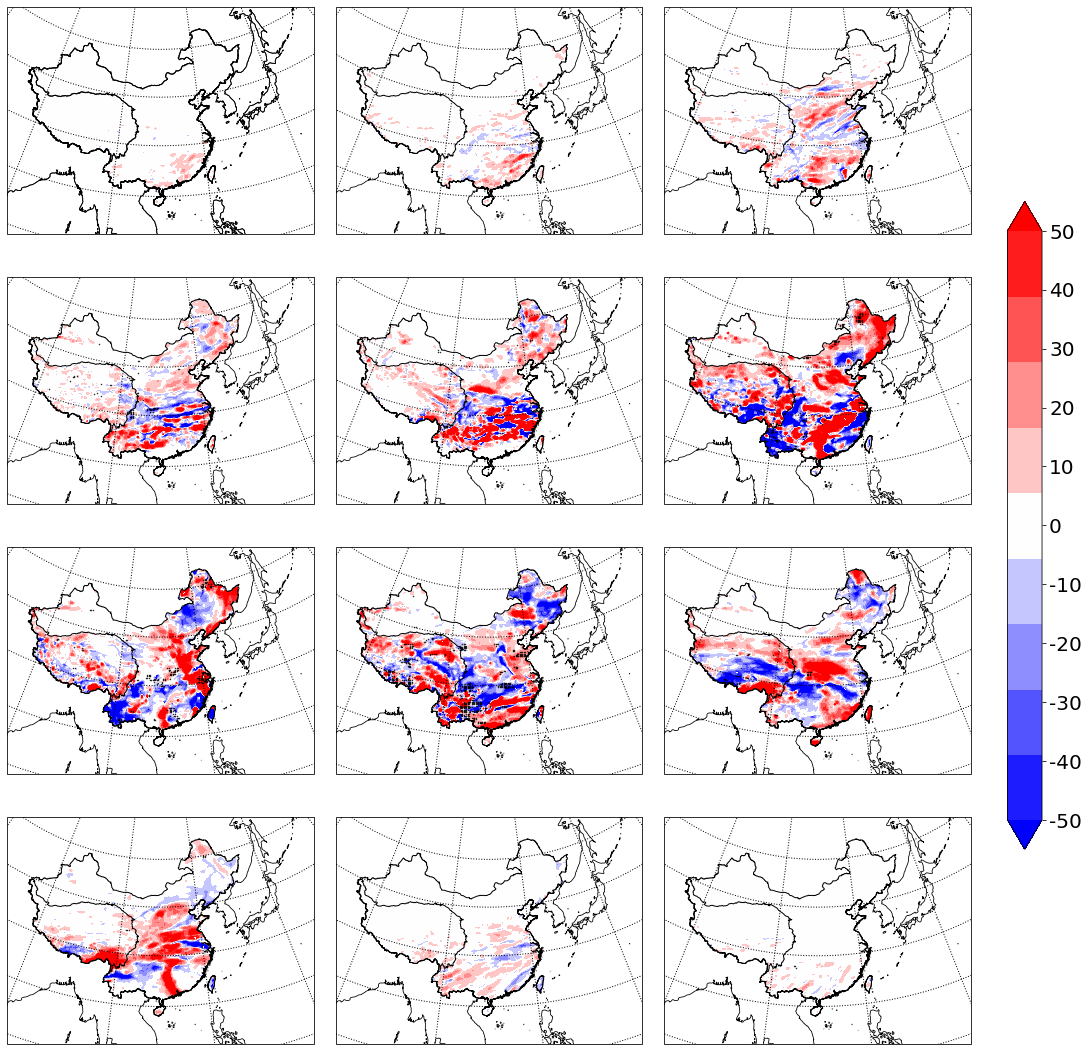

In [46]:
#monthly precipitation effect
# make plot
pre_limit = np.linspace(-50,50,10)

fig = plt.figure(figsize=(24, 18))

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.set_facecolor('none')
fig.set_edgecolor('none')

grid = AxesGrid(fig, 111, axes_class=axes_class,
                 nrows_ncols=(4, 3),
                 axes_pad=(0.3, 0.6),  # pad between axes in inch.
#                  cbar_location='bottom',
#                  cbar_mode='single',
#                  cbar_pad=0.2,
#                  cbar_size='5%',
                 share_all=True,
                 label_mode=" ")
p1=grid[0].contourf(to_np(lons),
                    to_np(lats),to_np(precip_effect(output_rm_grass_spin,1)[0]),50,
                    transform=crs.PlateCarree(),
                    cmap='bwr',
                    levels=pre_limit,
                    extend='both')
grid[0].coastlines('50m', linewidth=0.8)
grid[0].add_geometries(china.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[0].add_geometries(state_shapes.geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='k',linewidth=1.0) 
grid[0].set_xlim(cartopy_xlim(smooth))
grid[0].set_ylim(cartopy_ylim(smooth))
for i in range(1,13):
    data = precip_effect(output_rm_grass_spin,i)[0]
    grid0 = i-1
    plot_china(data,pre_limit,grid0)
    grid[grid0].scatter(to_np(precip_effect(output_rm_grass_spin,i)[1]),
                to_np(precip_effect(output_rm_grass_spin,i)[2]),
                s=0.2,c='k',transform=crs.PlateCarree())

cbar_ax = fig.add_axes([0.8, 0.25, 0.02, 0.5]) #[与主图间隔，上下位置，宽度，高度]
cb=fig.colorbar(p1,cax=cbar_ax,
                orientation='vertical')

cb.set_ticks(ticks=[-50,-40,-30,-20,-10,0,10,20,30,40,50,60])
cb.ax.set_yticklabels([-50,-40,-30,-20,-10,0,10,20,30,40,50],fontsize=20)